# Transpiler

The {func}`~.generate_boxing_pass_manager` function is a flexible and convenient tool to
build a {class}`qiskit.transpiler.PassManager` able to group the circuit instructions into annotated boxes.
Whether you want to automate your workflow, you are interested in trying different boxing strategies for your
circuits, or you simply want a quick and easy alternative to grouping and annotating by hand,
{func}`~.generate_boxing_pass_manager` can help you achieve your goals.

This guide illustrates how to use {func}`~.generate_boxing_pass_manager` and its arguments.
To highlight the effects of each of the function's arguments, in the sections that follow we will mainly target
the circuit below.

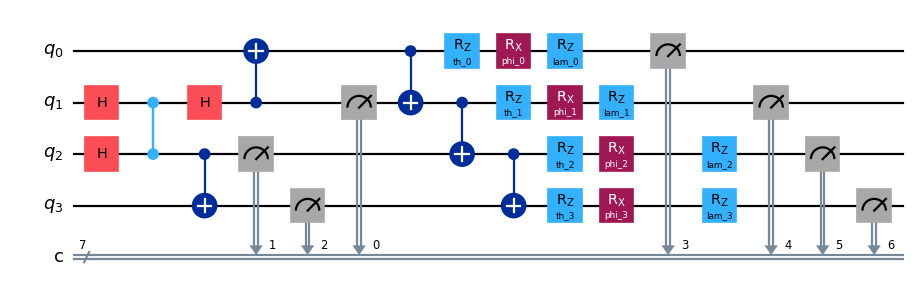

In [1]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(4, 7)
circuit.h(1)
circuit.h(2)
circuit.cz(1, 2)
circuit.h(1)
circuit.cx(1, 0)
circuit.cx(2, 3)
circuit.measure(range(1, 4), range(3))
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.cx(2, 3)
for qubit in range(4):
    circuit.rz(Parameter(f"th_{qubit}"), qubit)
    circuit.rx(Parameter(f"phi_{qubit}"), qubit)
    circuit.rz(Parameter(f"lam_{qubit}"), qubit)
circuit.measure(range(4), range(3, 7))

circuit.draw("mpl", scale=0.8)

## Group operations into boxes

The argument ``enable_gates`` can be set to ``True`` or ``False`` to specify whether the two-qubit gates should be grouped into
boxes. Similarly, ``enable_measures`` allows specifying whether or not measurements should be grouped. The following
snippet shows an example where both gates and measurements are grouped.

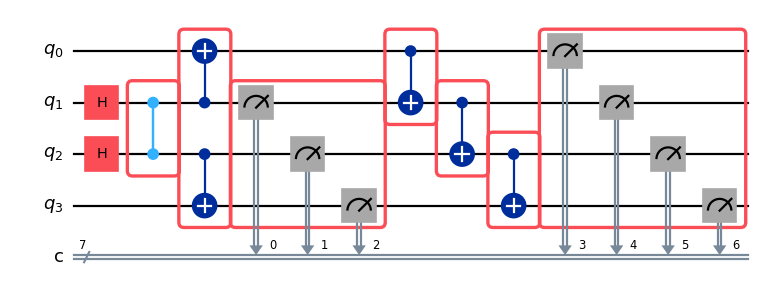

In [2]:
from samplomatic.transpiler import generate_boxing_pass_manager

boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
)
transpiled_circuit = boxing_pass_manager.run(circuit)
transpiled_circuit.draw("mpl", scale=0.8)

As can be seen in the figure, the pass manager creates boxes of two types: those that contain a single layer of
two-qubit gates, and those that contain a single layer of measurements. This separation reflects standard practices
in noise learning and mitigation protocols, which usually target layers of homogeneous operations. The two-qubit gates
and measurements are placed in the leftmost box that can accommodate them, and every single-qubit gates is placed in
the same box as the two-qubit gate or measurement they preceed.

The following snippet shows another example where ``enable_gates`` is set to ``False``. As can be seen, the two-qubit
gates are not grouped into boxes, nor are the single-qubit gates that preceed them.

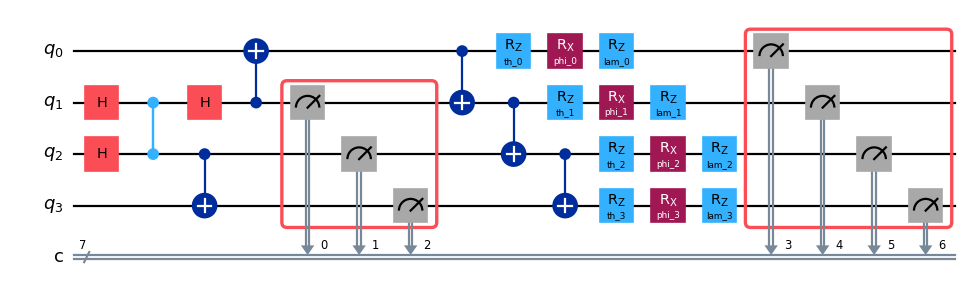

In [3]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=False,
    enable_measures=True,
)
transpiled_circuit = boxing_pass_manager.run(circuit)
transpiled_circuit.draw("mpl", scale=0.8)

## Choose how to annotate your boxes

All the two-qubit gates and measurement boxes in the returned circuit own left-dressed annotations. In particular,
all the boxes that contain two-qubit gates are annotated with a {class}`.~Twirl`, while for measurement boxes, users can
choose between {class}`.~Twirl`, {class}`.~BasisTranform` (with ``mode`` aset to ``"measure"``), or both. The following code
generates a circuit where the all the boxes are twirled, and the measurement boxes are additionally annotated with
{class}`.~BasisTranform`.

In [4]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    measure_annotations="all",
)
transpiled_circuit = boxing_pass_manager.run(circuit)

## Prepare your circuit for noise injection

The ``inject_noise_targets`` allows specifying what boxes should receive an {class}`.~InjectNoise` annotation. As an example,
the following snippet generates a circuit where the two-qubit gates boxes own an {class}`.~InjectNoise` annotation but the
measurement boxes do not.

In [5]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    inject_noise_targets="gates",
)
transpiled_circuit = boxing_pass_manager.run(circuit)

If a circuit contains two or more boxes that are equivalent up to single-qubit gates, all of them are annotated with
an {class}`.~InjectNoise` annotation with the same ``ref``. Thus, the number of unique ``ref``s in the returned
circuit is equal to the number of unique boxes, with uniqueness defined up to single-qubit gates.

By selecting the appropriate value for ``inject_noise_strategy``, users can decide whether the {class}`.~InjectNoise` annotations
should have:

* ``modifier_ref=''``, recommended when modifying the noise maps prior to sampling from them is not required,
* ``modifier_ref=ref``, recommended when all the noise maps need to be scaled uniformly by the same factor, or
* a unique value of ``modifier_ref``, recommended when every noise map needs to be scaled by a different factor.

The following code generates a circuit where the two-qubit gates boxes own an {class}`.~InjectNoise` annotation with unique
values of ``modifier_ref``.

In [6]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    inject_noise_targets="gates",
    inject_noise_strategy="individual_modification",
)
transpiled_circuit = boxing_pass_manager.run(circuit)

## Select a twirling strategy

The boxing pass manager begins by making choices about which entangling gates and measurement instructions should appear in the same boxes.
Once this is accomplished, boxes will not in general be full-width---they will likely include on only a subset of the qubits that are active in the circuit or present in the backend target.
In typical configurations of the boxing pass manager, since all qubits a box instruction acts on are twirled (even those for which no instruction inside the box act on), having partial-width boxes affects the noise-tailoring effects of twirling; the idling qubits are not twirled and can, for example, build up coherent errors while the box is applied.
The ``twirling_strategy`` provides options for extending the qubits owned by each box, and so modifying the number of idling qubits:

 * ``"active"`` (default) does not extend the boxes to any idling qubits.
 * ``"active_accum"`` extends all boxes to those qubits that have already been acted on by some prior instruction in the circuit. This is useful if you want to leave qubits at the start of the circuit in their ground state for as long as possible by not twirling them until they become active.
 * ``"active_circuit"`` extends all boxes to those qubits that are acted on by any instruction in the entire circuit. This is useful if you have a structured circuit with repeated entangling layers and you want to minimize the number of unique boxes because each one will need to have its noise learned.
 * ``"all"`` extends all boxes to all qubits in all quantum registers of the circuit. This is useful as an extension to ``"active_circuit"`` where you want all qubits in the QPU to always be twirled.

To demonstrate, we apply each of the strategies to our base circuit and draw the resulting outcomes.

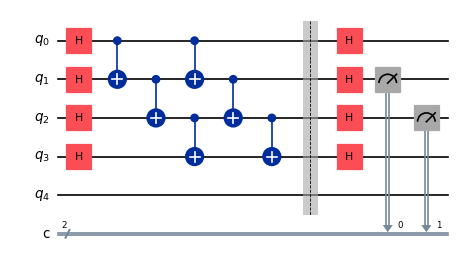

In [7]:
circuit = QuantumCircuit(5, 2)
circuit.h(range(4))
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.cx(2, 3)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.cx(2, 3)
circuit.barrier()
circuit.h(range(4))
circuit.measure([1, 2], [0, 1])

circuit.draw("mpl", scale=0.6)

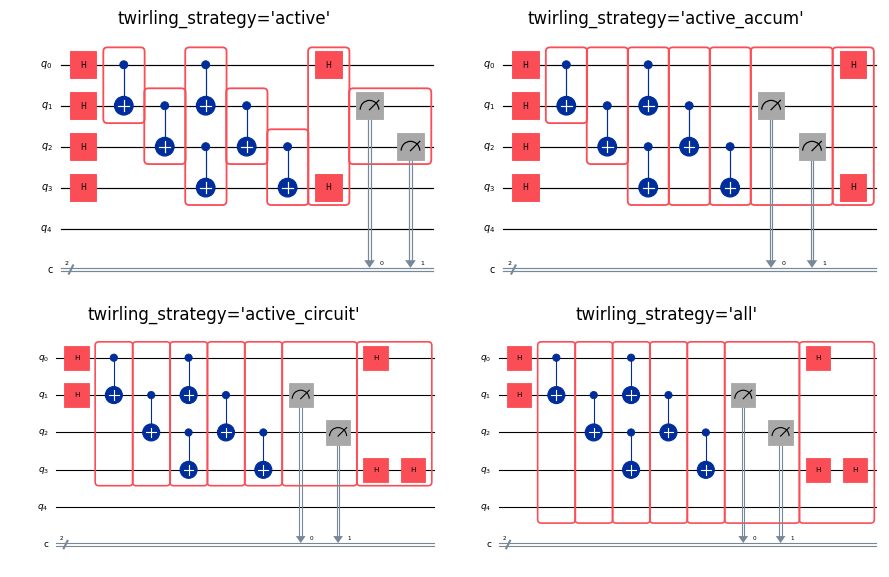

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
for idx, strategy in enumerate(["active", "active_accum", "active_circuit", "all"]):
    ax = plt.subplot(2, 2, idx + 1)
    pm = generate_boxing_pass_manager(twirling_strategy=strategy, remove_barriers="never")
    transpiled_circuit = pm.run(circuit)
    fig = transpiled_circuit.draw("mpl", scale=0.8, ax=ax)
    ax.set_title(f"twirling_strategy='{strategy}'")

plt.tight_layout()

## Specify how to treat barriers

By default, barriers are removed from the circuit after all entangling gates and measurement instructions have been boxed as instructed, including their extensions due to the ``twirling_strategy`` selection, but prior to single-qubit gates being added to the box immediately on their right, if possible.

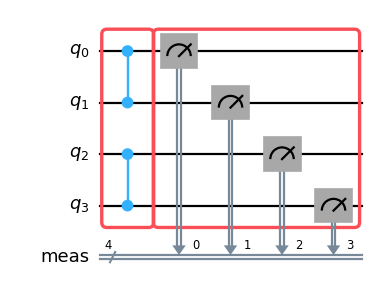

In [9]:
circuit_with_barrier = QuantumCircuit(4)
circuit_with_barrier.cz(0, 1)
circuit_with_barrier.barrier()
circuit_with_barrier.cz(2, 3)
circuit_with_barrier.measure_all()

boxing_pass_manager = generate_boxing_pass_manager()
transpiled_circuit = boxing_pass_manager.run(circuit_with_barrier)
transpiled_circuit.draw("mpl", scale=0.8)

Setting ``remove_barriers`` to ``False`` allows preserving the barriers.

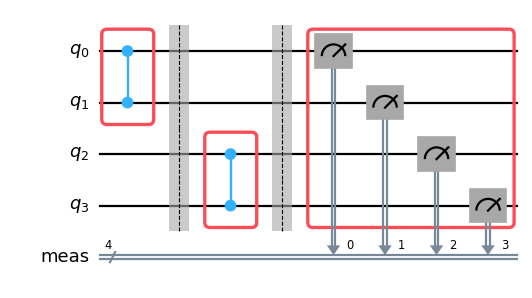

In [10]:
boxing_pass_manager = generate_boxing_pass_manager(
    remove_barriers=False,
)

transpiled_circuit = boxing_pass_manager.run(circuit_with_barrier)
transpiled_circuit.draw("mpl", scale=0.8)

Notice that when two gates are separated by a barrier, setting ``remove_barriers`` to ``True`` potentially
allows them to be placed into the same box. However, if ``remove_barriers`` is set to ``False``, they are
sure to be placed into different boxes. Thus, choosing to preserve the barriers guarantees that the
alignment and schedule of gates in the input circuit are respected, but it generally results in circuits
with larger depths.

## Incorporate Samplomatic's pass manager into `Qiskit`'s preset pass managers

The code below shows how to incorporate {func}`~.generate_boxing_pass_manager` into one of Qiskit's preset pass managers. The transpiled circuit is ISA and contains boxes.

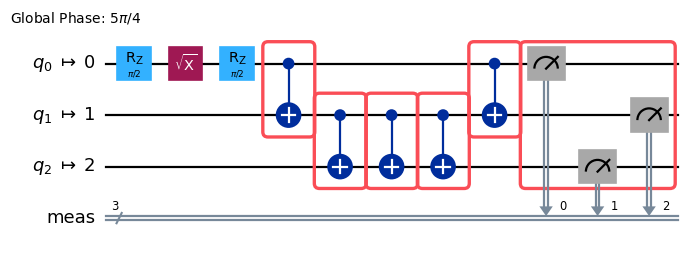

In [11]:
from qiskit.transpiler import generate_preset_pass_manager

preset_pass_manager = generate_preset_pass_manager(
    basis_gates=["rz", "sx", "cx"],
    coupling_map=[[0, 1], [1, 2]],
    optimization_level=0,
)
boxing_pass_manager = generate_boxing_pass_manager()

# Run the boxing pass manager after the scheduling stage
preset_pass_manager.post_scheduling = boxing_pass_manager

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.measure_all()

transpiled_circuit = preset_pass_manager.run(circuit)
transpiled_circuit.draw("mpl", scale=0.8)

## Build your circuit

Every pass manager produced by {func}`~.generate_boxing_pass_manager` returns
circuits that can be successfully turned into a template/samplex pair by {func}`~.build`. As an
example, the following code calls the {func}`~.build` function on a circuit produced by a boxing pass
manager.

In [12]:
from samplomatic import build

boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
)
transpiled_circuit = boxing_pass_manager.run(circuit)

template, samplex = build(transpiled_circuit)

In order to ensure that any transpiled circuit can be successfully built, the pass managers know how to
include additional boxes when they are needed. As an example, consider the circuit below, which ends with an
unmeasured qubit ``0``.

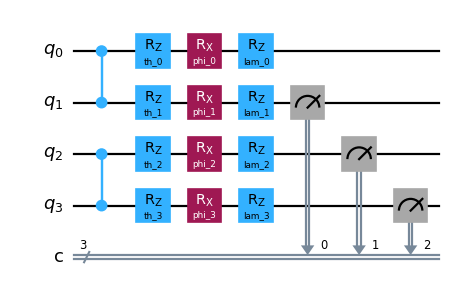

In [13]:
circuit_with_unmeasured_qubit = QuantumCircuit(4, 3)
circuit_with_unmeasured_qubit.cz(0, 1)
circuit_with_unmeasured_qubit.cz(2, 3)
for qubit in range(4):
    circuit_with_unmeasured_qubit.rz(Parameter(f"th_{qubit}"), qubit)
    circuit_with_unmeasured_qubit.rx(Parameter(f"phi_{qubit}"), qubit)
    circuit_with_unmeasured_qubit.rz(Parameter(f"lam_{qubit}"), qubit)
circuit_with_unmeasured_qubit.measure(range(1, 4), range(3))

circuit_with_unmeasured_qubit.draw("mpl", scale=0.8)

Drawing left-dressed boxes around the gates and the measurements would result in a circuit that has uncollected
virtual gates on qubit ``0``, and calling {func}`~.build` on this circuit would result in an error. To
avoid this, the pass managers returned by {func}`~.generate_boxing_pass_manager` are allowed
to add right-dressed boxes to act as collectors. As an example, in the following snippet qubit ``0`` is
terminated by a right-dressed box that picks up the uncollected virtual gate. The single-qubit gates acting on qubit
``0`` are also placed inside the box, in order to minimise the depth of the resulting circuit.

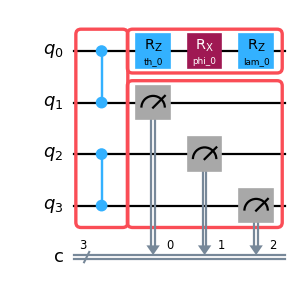

In [14]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
)
transpiled_circuit = boxing_pass_manager.run(circuit_with_unmeasured_qubit)
transpiled_circuit.draw("mpl", scale=0.8)

In another example, a right-dressed box is added to collect the virtual gates that would otherwise remain
uncollected due to the unboxed measurements.

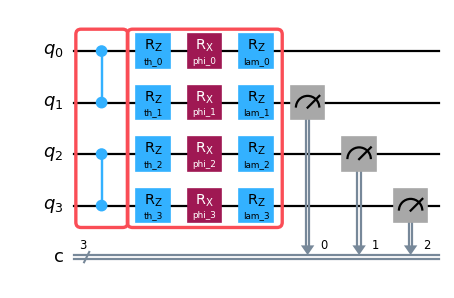

In [15]:
boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=False,
)
transpiled_circuit = boxing_pass_manager.run(circuit_with_unmeasured_qubit)
transpiled_circuit.draw("mpl", scale=0.8)